In [35]:
%reset

# Questions before start:
We have a bunch of csv files, where each one is divided into categories:
1. Country (belgium, england, france, germany, greece, italy, netherlands, portugal, scotland, spain, turkey)
2. League (0, 1, 2, 3)
3. Season (2000-2001, 2001-2002, ..., 2021-2022)

Should we merge all the csv files into one big dataframe? Or should we keep them separate? 
If we merge them, how do we keep track of the different leagues and seasons?  

## Thoughts:
We could merge them into one big dataframe, and provide analysis on the whole dataset. 
In case we need analyse a specific league or season, we can filter the dataframe accordingly.

**Before merging**, we should add a column for the league and season.


In [ ]:
# TODO: 
#  1. try to find in what city match occurred (add as feature), and find related weather data for that city and day (as feature)
#  (DONE) 2. check if particular bookmaker appears only in one (or more) country 
#  (DONE) 3. check if particular bookmaker appears only in one (or more) league
#  4. add weekend/weekday as feature (as "Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.")
#  5. add "number of days since last match" as feature
#  6. check correlations in odds across bookmakers, so that we can drop some columns (probably keep only one bookmaker)


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns

In [37]:
# csv_files = sorted(glob(f'data/train/**/*.csv', recursive=True))

def read_data(folder_path):
    df = pd.DataFrame()
    for file_path in sorted(glob(f'{folder_path}/**/*.csv', recursive=True)):
        csv_file_df = pd.read_csv(file_path)
        
        # Rename HT and AT columns to HomeTeam and AwayTeam
        if 'HT' or 'AT' in csv_file_df.columns:
            csv_file_df.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'}, inplace=True)
        
        # Extract country, league, and season from file path
        parts = file_path.split('/')
        country = parts[-3]
        league = parts[-2]
        season = parts[-1].split('.')[0]

        # Add country, league, and season as features to the front
        csv_file_df.insert(0, 'Country', country)
        csv_file_df.insert(1, 'League', league)
        csv_file_df.insert(2, 'Season', season)

        # Convert date to datetime format and sort by date
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%y', errors='coerce')
        csv_file_df = csv_file_df.sort_values(by='Date')
        
        df = pd.concat([df, csv_file_df], ignore_index=True, axis=0, join='outer', sort=False)

    return df

In [38]:
# Read all training data
train_df = read_data('data/train')

In [39]:
# Display unique column names and their count
unique_columns = train_df.columns.unique()
column_count = len(unique_columns)

print("Unique Column Names:")
print(unique_columns)

print("\nNumber of Unique Columns:", column_count)

Unique Column Names:
Index(['Country', 'League', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam',
       'FTHG', 'FTAG', 'FTR',
       ...
       'Unnamed: 72', 'LB', 'LB.1', 'LB.2', 'Unnamed: 24', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 53', 'Unnamed: 106'],
      dtype='object', length=213)

Number of Unique Columns: 213


In [40]:
# Drop empty columns starting with "Unnamed"
train_df = train_df.filter(regex='^(?!Unnamed).*$')


In [41]:
# Split columns into categories about match (results data), Match Statistics, and betting odds (as in notes.txt)
# Rename columns later
match_data = {
    "League": "League",
    "Season": "Season",
    "Country": "Country",
    "Div": "League_Division",
    "Date": "Match_Date",
    "Time": "Time_of_match_kick_off",
    "HomeTeam": "Home_Team",
    "AwayTeam": "Away_Team",
    "FTHG": "Full_Time_Home_Team_Goals",
    "FTAG": "Full_Time_Away_Team_Goals",
    "FTR": "Full_Time_Result",
    "HTHG": "Half_Time_Home_Team_Goals",
    "HTAG": "Half_Time_Away_Team_Goals",
    "HTR": "Half_Time_Result"
}

match_statistics = {
    "Attendance": "Crowd_Attendance",
    "Referee": "Match_Referee",
    "HS": "Home_Team_Shots",
    "AS": "Away_Team_Shots",
    "HST": "Home_Team_Shots_on_Target",
    "AST": "Away_Team_Shots_on_Target",
    "HHW": "Home_Team_Hit_Woodwork",
    "AHW": "Away_Team_Hit_Woodwork",
    "HC": "Home_Team_Corners",
    "AC": "Away_Team_Corners",
    "HF": "Home_Team_Fouls_Committed",
    "AF": "Away_Team_Fouls_Committed",
    "HFKC": "Home_Team_Free_Kicks_Conceded",
    "AFKC": "Away_Team_Free_Kicks_Conceded",
    "HO": "Home_Team_Offsides",
    "AO": "Away_Team_Offsides",
    "HY": "Home_Team_Yellow_Cards",
    "AY": "Away_Team_Yellow_Cards",
    "HR": "Home_Team_Red_Cards",
    "AR": "Away_Team_Red_Cards",
    "HBP": "Home_Team_Bookings_Points",
    "ABP": "Away_Team_Bookings_Points"
}

betting_odds_1x2_match = {
    "B365H": "Bet365_home_win_odds",
    "B365D": "Bet365_draw_odds",
    "B365A": "Bet365_away_win_odds",
    "BSH": "Blue_Square_home_win_odds",
    "BSD": "Blue_Square_draw_odds",
    "BSA": "Blue_Square_away_win_odds",
    "BWH": "Bet&Win_home_win_odds",
    "BWD": "Bet&Win_draw_odds",
    "BWA": "Bet&Win_away_win_odds",
    "GBH": "Gamebookers_home_win_odds",
    "GBD": "Gamebookers_draw_odds",
    "GBA": "Gamebookers_away_win_odds",
    "IWH": "Interwetten_home_win_odds",
    "IWD": "Interwetten_draw_odds",
    "IWA": "Interwetten_away_win_odds",
    "LBH": "Ladbrokes_home_win_odds",
    "LBD": "Ladbrokes_draw_odds",
    "LBA": "Ladbrokes_away_win_odds",
    "PSH": "Pinnacle_home_win_odds",
    "PSD": "Pinnacle_draw_odds",
    "PSA": "Pinnacle_away_win_odds",
    "SOH": "Sporting_Odds_home_win_odds",
    "SOD": "Sporting_Odds_draw_odds",
    "SOA": "Sporting_Odds_away_win_odds",
    "SBH": "Sportingbet_home_win_odds",
    "SBD": "Sportingbet_draw_odds",
    "SBA": "Sportingbet_away_win_odds",
    "SJH": "Stan_James_home_win_odds",
    "SJD": "Stan_James_draw_odds",
    "SJA": "Stan_James_away_win_odds",
    "SYH": "Stanleybet_home_win_odds",
    "SYD": "Stanleybet_draw_odds",
    "SYA": "Stanleybet_away_win_odds",
    "VCH": "VC_Bet_home_win_odds",
    "VCD": "VC_Bet_draw_odds",
    "VCA": "VC_Bet_away_win_odds",
    "WHH": "William_Hill_home_win_odds",
    "WHD": "William_Hill_draw_odds",
    "WHA": "William_Hill_away_win_odds",
    "Bb1X2": "Number_of_BetBrain_bookmakers_used",
    "BbMxH": "Betbrain_maximum_home_win_odds",
    "BbAvH": "Betbrain_average_home_win_odds",
    "BbMxD": "Betbrain_maximum_draw_odds",
    "BbAvD": "Betbrain_average_draw_win_odds",
    "BbMxA": "Betbrain_maximum_away_win_odds",
    "BbAvA": "Betbrain_average_away_win_odds",
    "MaxH": "Market_maximum_home_win_odds",
    "MaxD": "Market_maximum_draw_win_odds",
    "MaxA": "Market_maximum_away_win_odds",
    "AvgH": "Market_average_home_win_odds",
    "AvgD": "Market_average_draw_win_odds",
    "AvgA": "Market_average_away_win_odds",
}

betting_odds_total_goals = {
    "BbOU": "Number_BetBrain_over_under_2.5_goals_averages_and_maximums",
    "BbMx>2.5": "Betbrain_maximum_over_2.5_goals",
    "BbAv>2.5": "Betbrain_average_over_2.5_goals",
    "BbMx<2.5": "Betbrain_maximum_under_2.5_goals",
    "BbAv<2.5": "Betbrain_average_under_2.5_goals",
    "GB>2.5": "Gamebookers_over_2.5_goals",
    "GB<2.5": "Gamebookers_under_2.5_goals",
    "B365>2.5": "Bet365_over_2.5_goals",
    "B365<2.5": "Bet365_under_2.5_goals",
    "P>2.5": "Pinnacle_over_2.5_goals",
    "P<2.5": "Pinnacle_under_2.5_goals",
    "Max>2.5": "Market_maximum_over_2.5_goals",
    "Max<2.5": "Market_maximum_under_2.5_goals",
    "Avg>2.5": "Market_average_over_2.5_goals",
    "Avg<2.5": "Market_average_under_2.5_goals",
}

betting_odds_asian_handicap = {
    "BbAH": "Number_BetBrain_handicap_averages_and_maximums",
    "BbAHh": "Betbrain_size_of_handicap_home_team",
    "AHh": "Market_size_handicap_home_team_since_2019/2020",
    "BbMxAHH": "Betbrain_maximum_Asian_handicap_home_team_odds",
    "BbAvAHH": "Betbrain_average_Asian_handicap_home_team_odds",
    "BbMxAHA": "Betbrain_maximum_Asian_handicap_away_team_odds",
    "BbAvAHA": "Betbrain_average_Asian_handicap_away_team_odds",
    "GBAHH": "Gamebookers_Asian_handicap_home_team_odds",
    "GBAHA": "Gamebookers_Asian_handicap_away_team_odds",
    "GBAH": "Gamebookers_size_of_handicap_home_team",
    "LBAHH": "Ladbrokes_Asian_handicap_home_team_odds",
    "LBAHA": "Ladbrokes_Asian_handicap_away_team_odds",
    "LBAH": "Ladbrokes_size_of_handicap_home_team",
    "B365AHH": "Bet365_Asian_handicap_home_team_odds",
    "B365AHA": "Bet365_Asian_handicap_away_team_odds",
    "B365AH": "Bet365_size_of_handicap_home_team",
    "PAHH": "Pinnacle_Asian_handicap_home_team_odds",
    "PAHA": "Pinnacle_Asian_handicap_away_team_odds",
    "MaxAHH": "Market_maximum_Asian_handicap_home_team_odds",
    "MaxAHA": "Market_maximum_Asian_handicap_away_team_odds",
    "AvgAHH": "Market_average_Asian_handicap_home_team_odds",
    "AvgAHA": "Market_average_Asian_handicap_away_team_odds",
}

closing_odds = {
    'AHCh': 'Market_size_handicap_home_team_since_2019/2020_close',
    'AvgC<2.5': 'Average_under_2.5_goals_close',
    'AvgC>2.5': 'Average_over_2.5_goals_close',
    'AvgCA': 'Away_win_odds_average_close',
    'AvgCAHA': 'Asian_handicap_away_team_odds_average_close',
    'AvgCAHH': 'Asian_handicap_home_team_odds_average_close',
    'AvgCD': 'Draw_odds_average_close',
    'AvgCH': 'Home_win_odds_average_close',
    'B365C<2.5': 'Bet365_under_2.5_goals_close',
    'B365C>2.5': 'Bet365_over_2.5_goals_close',
    'B365CA': 'Bet365_away_win_odds_close',
    'B365CAHA': 'Bet365_Asian_handicap_away_team_odds_close',
    'B365CAHH': 'Bet365_Asian_handicap_home_team_odds_close',
    'B365CD': 'Bet365_draw_odds_close',
    'B365CH': 'Bet365_home_win_odds_close',
    'BWCA': 'Bet&Win_away_win_odds_close',
    'BWCD': 'Bet&Win_draw_odds_close',
    'BWCH': 'Bet&Win_home_win_odds_close',
    'IWCA': 'Interwetten_away_win_odds_close',
    'IWCD': 'Interwetten_draw_odds_close',
    'IWCH': 'Interwetten_home_win_odds_close',
    'MaxC<2.5': 'Market_maximum_under_2.5_goals_close',
    'MaxC>2.5': 'Market_maximum_over_2.5_goals_close',
    'MaxCA': 'Market_maximum_away_win_odds_close',
    'MaxCAHA': 'Market_maximum_Asian_handicap_away_team_odds_close',
    'MaxCAHH': 'Market_maximum_Asian_handicap_home_team_odds_close',
    'MaxCD': 'Market_maximum_draw_odds_close',
    'MaxCH': 'Market_maximum_home_win_odds_close',
    'PC<2.5': 'Pinnacle_under_2.5_goals_close',
    'PC>2.5': 'Pinnacle_over_2.5_goals_close',
    'PCAHA': 'Pinnacle_Asian_handicap_away_team_odds_close',
    'PCAHH': 'Pinnacle_Asian_handicap_home_team_odds_close',
    'PSCA': 'Pinnacle_away_win_odds_close',
    'PSCD': 'Pinnacle_draw_odds_close',
    'PSCH': 'Pinnacle_home_win_odds_close',
    'VCCA': 'VC_Bet_away_win_odds_close',
    'VCCD': 'VC_Bet_draw_odds_close',
    'VCCH': 'VC_Bet_home_win_odds_close',
    'WHCA': 'William_Hill_away_win_odds_close',
    'WHCD': 'William_Hill_draw_odds_close',
    'WHCH': 'William_Hill_home_win_odds_close',
}


In [42]:
# Number of columns in each category
# Combine all sets
col_dicts = [
    betting_odds_asian_handicap,
    betting_odds_total_goals,
    betting_odds_1x2_match,
    match_statistics,
    match_data,
    closing_odds
]

# Calculate the total number of columns in dictionaries
num_col = sum(map(len, col_dicts))

print(f"Number of columns in train_df: {len(train_df.columns)}")
print(f"Number of documented columns: {num_col}")

Number of columns in train_df: 169
Number of documented columns: 166


In [43]:
# Combine all dictionary keys into a single set
col_dicts_keys = set().union(
    betting_odds_asian_handicap.keys(),
    betting_odds_total_goals.keys(),
    betting_odds_1x2_match.keys(),
    match_statistics.keys(),
    match_data.keys(),
    closing_odds.keys()
)

# Get the columns in train_df that are not in the combined set of keys
extra_columns = set(train_df.columns) - col_dicts_keys

# Display the extra columns
print("Columns not present in dictionaries:")
for column in extra_columns:
    print(column)


Columns not present in dictionaries:
LB.1
LB.2
LB


Maybe we should drop them, as we don't know what they are.

### Thought: each bookmaker might be assigned to one country, so we can add a column for the country of the bookmaker

In [44]:
# Rename columns in train_df according to the dictionaries
for col_dict in col_dicts:
    train_df.rename(columns=col_dict, inplace=True)
    
# Identify duplicate columns
duplicate_columns = train_df.columns[train_df.columns.duplicated()]

# Print the duplicate columns
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: Index([], dtype='object')


In [45]:
# 2. check if particular bookmaker appears only in one (or more) country
bookmakers = ['Bet365', 
              'Blue_Square', 
              'Bet&Win', 
              'Gamebookers', 
              'Interwetten',
              'Ladbrokes', 
              'Pinnacle', 
              'Sporting_Odds', 
              'Sportingbet', 
              'Stan_James',
              'Stanleybet', 
              'VC_Bet', 
              'William_Hill']

df_test = train_df.copy()
# Create indicator columns for each bookmaker
for bookmaker in bookmakers:
    indicator_column = f'{bookmaker}_indicator'
    columns_to_check = [col for col in df_test.columns if bookmaker in col]
    df_test[indicator_column] = df_test[columns_to_check].any(axis=1).astype(int)

In [46]:
# List of indicator columns (replace this with your actual indicator columns)
indicator_columns = ['Bet365_indicator', 'Blue_Square_indicator', 'Bet&Win_indicator', 'Gamebookers_indicator',
                     'Interwetten_indicator', 'Ladbrokes_indicator', 'Pinnacle_indicator', 'Sporting_Odds_indicator',
                     'Sportingbet_indicator', 'Stan_James_indicator', 'Stanleybet_indicator', 'VC_Bet_indicator',
                     'William_Hill_indicator']

# Group by 'Country' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Country')[indicator_columns].sum().reset_index()


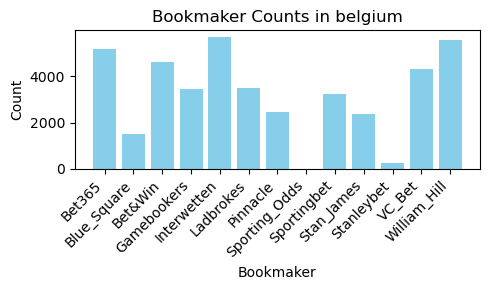

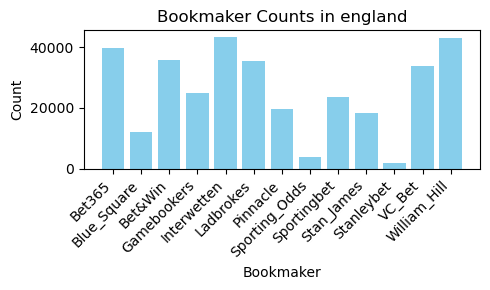

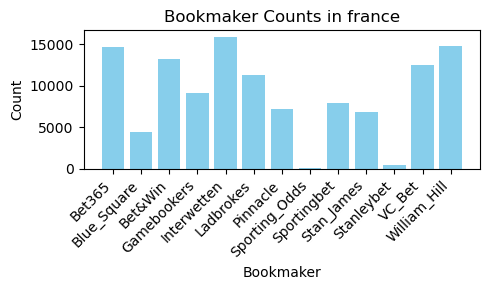

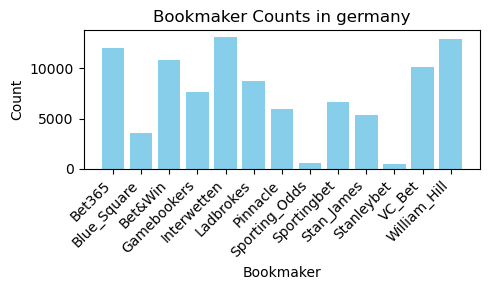

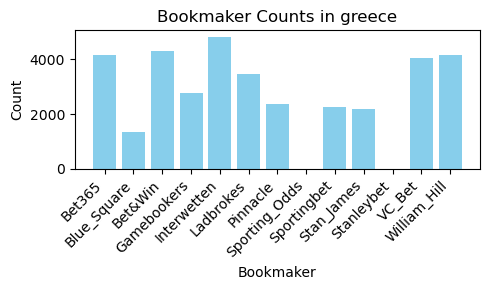

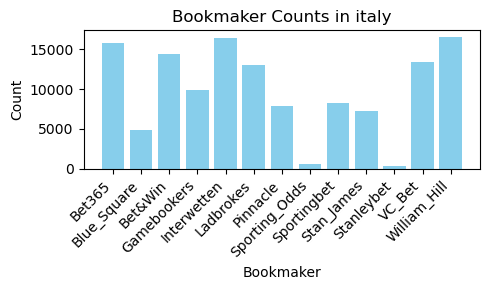

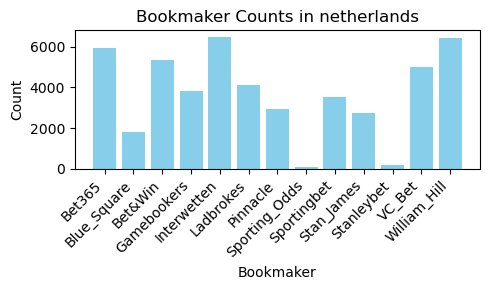

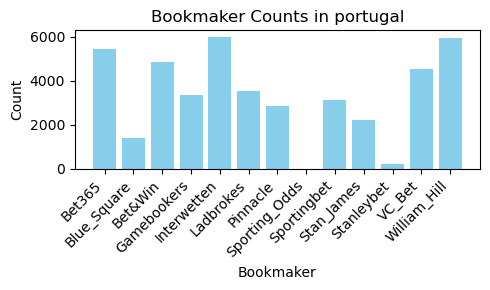

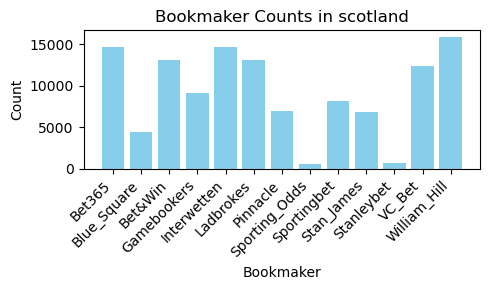

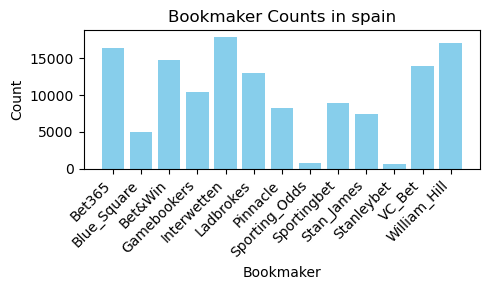

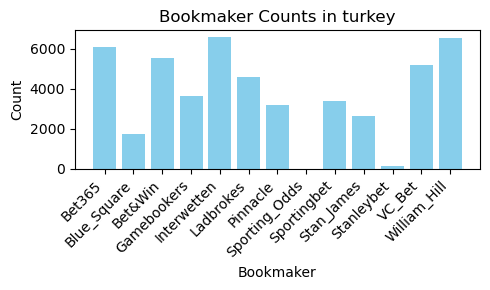

In [52]:
# Plot a bar chart for each country
for index, row in grouped_df.iterrows():
    country_name = row['Country']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {country_name}')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

### There is no significant difference in bet distribution between the bookmakers per country.

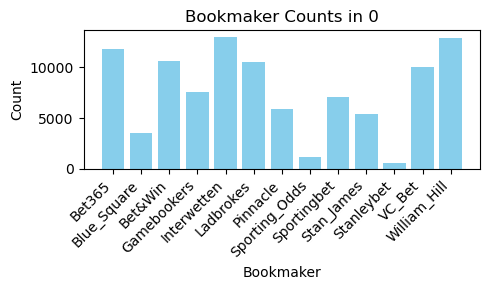

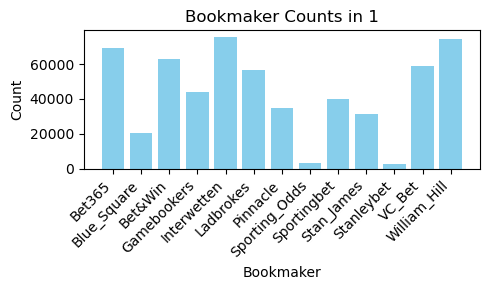

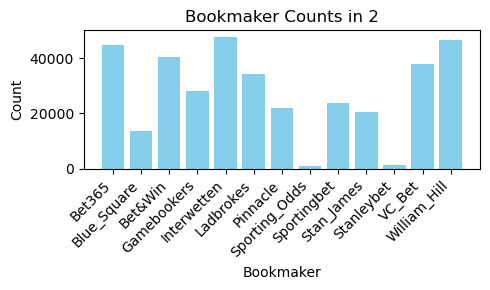

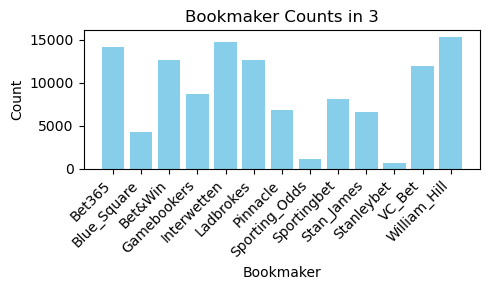

In [53]:
# Group by 'League' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('League')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['League']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} League')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

### There is no significant difference in bet distribution between the bookmakers per league.

## NAs treatment

In [56]:
train_df.describe()

,Full_Time_Home_Team_Goals,Full_Time_Away_Team_Goals,Half_Time_Home_Team_Goals,Half_Time_Away_Team_Goals,Gamebookers_home_win_odds,Gamebookers_draw_odds,Gamebookers_away_win_odds,Interwetten_home_win_odds,Interwetten_draw_odds,Interwetten_away_win_odds,...,Away_Team_Bookings_Points,Sporting_Odds_home_win_odds,Sporting_Odds_draw_odds,Sporting_Odds_away_win_odds,Ladbrokes_Asian_handicap_home_team_odds,Ladbrokes_Asian_handicap_away_team_odds,Ladbrokes_size_of_handicap_home_team,LB,LB.1,LB.2
count,154864.000000,154841.000000,154813.000000,154820.000000,88060.000000,88123.000000,88106.000000,150729.000000,150735.000000,150766.000000,...,6671.000000,6599.000000,6613.000000,6614.000000,5470.000000,5470.000000,5458.000000,110.000000,110.000000,107.000000
mean,2.216358,1.130883,0.655636,0.494206,2.275366,3.381363,3.950892,2.335784,3.382514,3.753866,...,20.914406,2.216488,3.391382,3.833776,1.911200,1.924793,-0.350500,1.985955,3.258182,3.808477
std,21.861876,1.108967,0.809382,0.708167,1.039952,0.613622,2.195107,1.155085,0.713629,2.251540,...,17.212936,0.983779,0.481409,2.078919,0.174042,0.124442,0.588259,0.434470,0.170338,1.309792
min,0.000000,-1.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,1.500000,1.030000,...,0.000000,1.060000,2.380000,1.140000,-2.250000,-0.500000,-2.250000,1.360000,3.000000,1.900000
25%,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,3.050000,2.550000,...,10.000000,1.700000,3.200000,2.620000,1.840000,1.840000,-0.750000,1.684250,3.200000,2.800000
50%,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,3.200000,...,20.000000,2.100000,3.250000,3.250000,1.920000,1.920000,-0.250000,1.909000,3.200000,3.500000
75%,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,4.200000,...,30.000000,2.400000,3.400000,4.500000,2.000000,2.000000,0.000000,2.237500,3.250000,4.333000
max,998.000000,13.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,70.000000,...,150.000000,13.000000,8.000000,21.000000,3.400000,4.000000,9.000000,3.500000,4.000000,8.000000


In [58]:
train_df.isna().sum()

Country                                         0
League                                          0
Season                                          0
League_Division                               311
Match_Date                                  31095
                                            ...  
Ladbrokes_Asian_handicap_away_team_odds    149703
Ladbrokes_size_of_handicap_home_team       149715
LB                                         155063
LB.1                                       155063
LB.2                                       155066
Length: 169, dtype: int64

In [ ]:
# com